In [1]:
from covertrace.data_array import Sites
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import abspath, dirname, join
from scipy.integrate import odeint
from scipy.optimize import fmin

%matplotlib inline

In [2]:
from covertrace import ops_filter
from covertrace import ops_plotter
from covertrace import ops_bool

In [3]:
data_folder = join(dirname(abspath(os.curdir)), 'covertrackdev', 'output')

## Estimation of k<sub>v</sub>

First obtain the parameter kv, ratio of cytosolic volume to nuclear volume. 
k_v can be robustly estimated when the dynamic range of the translcoation is large. 
We use the contidition where JNK reporter is activated by anisomycin and then inhibited by JNK inhibitor. 


In [4]:
parent_folder = join(data_folder, 'AnisoInh')
sub_folders = ['Pos001']
conditions = ['AnisoInh']
sites = Sites(parent_folder, sub_folders, conditions, file_name='df.npz')

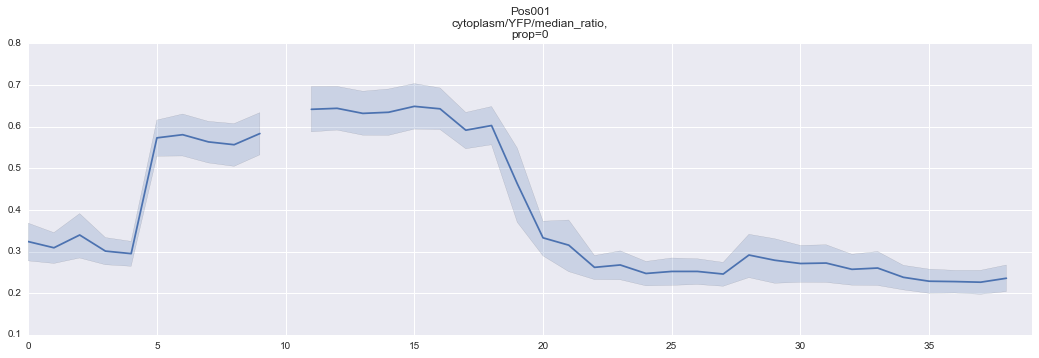

In [5]:
# First take a look at average traces for the cytoplasmic/nuclear ratio of median intensity. 
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)

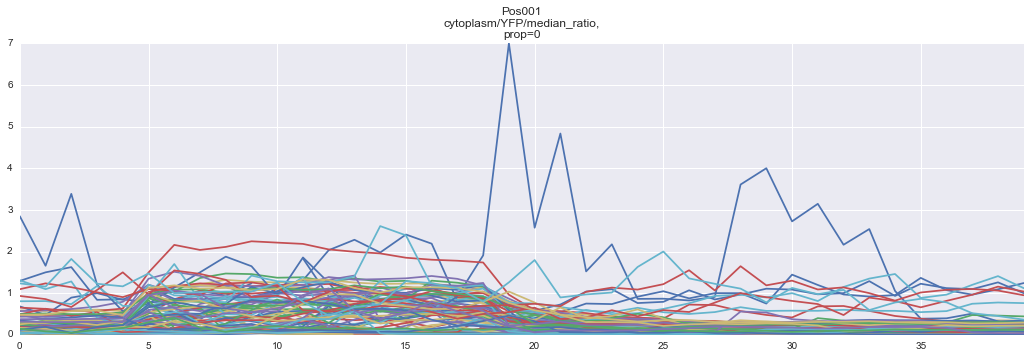

In [6]:
# You see that the activation of JNK reporter at frame 5 and inhibition around frame 20. 
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
plot_all = partial(ops_plotter.plot_all)
fig, axes = sites.iterate(plot_all)

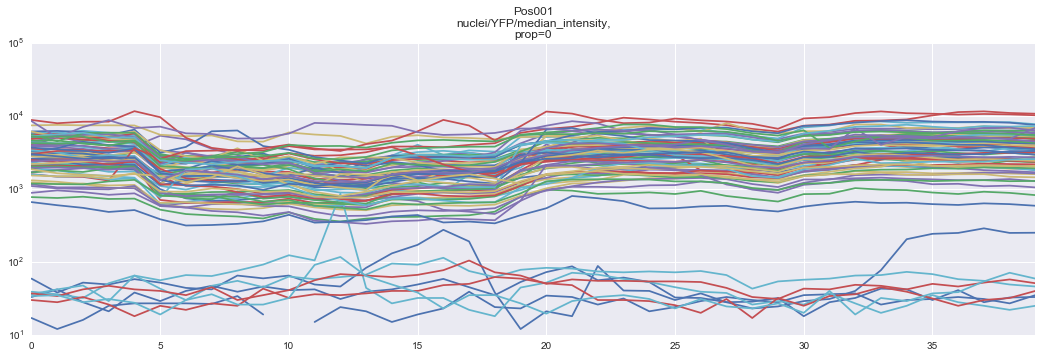

In [7]:
# You see some outliers above. The typical range of KTR is 0.5-2.
# One typical cause of these outliers is we have cells with almost no reporters. Check YFP intensity in nuclei. 
sites.staged.state = ['nuclei', 'YFP', 'median_intensity']
plot_all_log = partial(ops_plotter.plot_all, logy=True)
fig, axes = sites.iterate(plot_all_log)

Pos001: file_name is updated to arr_modified.npz


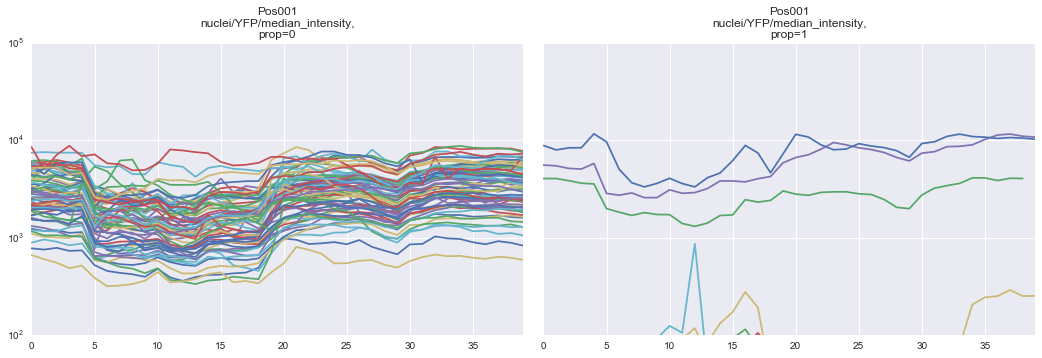

In [8]:
op = partial(ops_bool.filter_frames_by_range, LOWER=100)
sites.iterate(op, 1)
sites.propagate_prop(pid=1)
fig, axes = sites.iterate(plot_all_log)

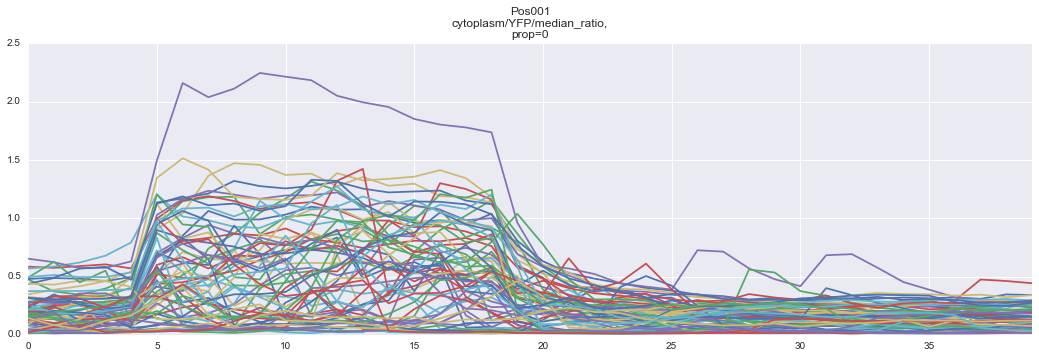

In [22]:
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
fig, axes = sites.iterate(plot_all)

In [19]:
sites.drop_prop(1)

Pos001: file_name is updated to arr_modified.npz


In [10]:
# Now you see cells having a low or no expression of reporters show noisy traces. 
# Further filter cells by taking 5-95 percentile of total intensity expression. 
# will add in the future. 

In [11]:
# Merge cells

In [31]:
# Now for each traces, take a minimum and maximum. 
# NEED TO RESET THE FRAME. ASK JAKE. 
for site in sites:
    r_n_1 = np.nanmean(site.data['nuclei', 'YFP', 'median_intensity'][0])
    r_n_2 = np.nanmean(site.data['nuclei', 'YFP', 'median_intensity'][20])
    r_c_1 = np.nanmean(site.data['cytoplasm', 'YFP', 'median_intensity'][0])
    r_c_2 = np.nanmean(site.data['cytoplasm', 'YFP', 'median_intensity'][20])


In [32]:
estimated_k_v = np.nanmean((r_n_2 - r_n_1)/(r_c_1 - r_c_2))
print estimated_k_v

-3.26402323061


## Estimation of k<sub>iu</sub>, k<sub>eu</sub>, k<sub>ip</sub>, k<sub>ep</sub>

In [ ]:
'''
The cytoplasmic translocation of KTR happens because phosphorylation decreases the export rate and increases
the import rate. Thus we would like to know the import and export rate contants for both phosphorylated reporters and 
non-phosphorylated reporters. 
To estimate these constants, we utilize the fact that JNK KTR AA and JNK KTR EE mutants approximate the unphosphorylated 
and phosphorylated state of the wild-type JNK KTR, respectively. 
'''

In [34]:
parent_folder_mut = join(data_folder, 'LMB')
sub_folders_mut = ['Pos003', 'Pos005']
conditions_mut = ['JNK_AA', 'JNK_EE']
sites_mut = Sites(parent_folder_mut, sub_folders_mut, conditions_mut, file_name='df.npz')
# Pos003 and Pos004
# Pos005 and Pos006
# inhibited at frame 5. 

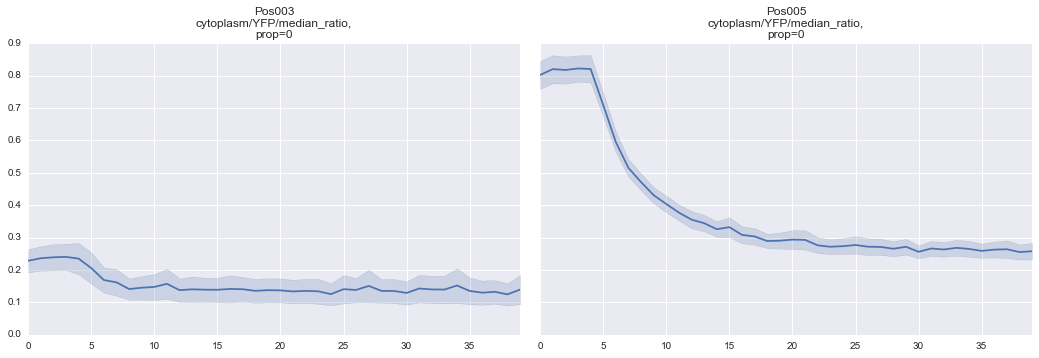

In [35]:
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
fig, axes = sites_mut.iterate(plot_tsplot)

In [377]:
pre_steady_state = sites_mut.Pos005.data.slice_arr[:, 1:5].mean(axis=1)
post_steady_state = sites_mut.Pos005.data.slice_arr[:, 25:].mean(axis=1)

estim_h = (post_steady_state/pre_steady_state).mean()  # Not clear
print estim_h

0.372436195012


In [230]:
aa_ratio = sites_mut.Pos003.data['cytoplasm', 'YFP', 'median_ratio']
ee_ratio = sites_mut.Pos005.data['cytoplasm', 'YFP', 'median_ratio']

In [237]:
estimated_k_v = abs(estimated_k_v)

In [366]:
def fit_ode_lmb(x, *args):
    sim_ratio, ratio_time_course = calc_sim_ratio(x, *args)
    return ((sim_ratio - ratio_time_course) ** 2).sum()

In [367]:
def calc_sim_ratio(x, *args):
    '''x = [tau, h, r]
    '''
    tau, h, r = x[0], x[1], x[2]
    time_pre, time_post, ratio_time_course, k_v = args[0], args[1], args[2], args[3]
    k_i = tau * r
    k_e = tau
    ini_r_c = 1.0
    ini_r_n = r
    
    pre_inh = odeint(ode_lmb, [ini_r_c, ini_r_n], time_pre, (k_v, k_i, k_e), rtol=1e-4)
    post_inh = odeint(ode_lmb, [pre_inh[-1][0], pre_inh[-1][1]], time_post, (k_v, k_i, k_e * h), rtol=1e-4)
    
    pre_inh_ratio = [i[0]/i[1] for i in pre_inh]
    post_inh_ratio = [i[0]/i[1] for i in post_inh]
    sim_ratio = np.array(pre_inh_ratio + post_inh_ratio)
    return sim_ratio, ratio_time_course

In [368]:
def ode_lmb(y, t, *args):
    # h = 1 for frame before 5
    k_v, k_i, k_e = args[0], args[1], args[2]
    r_c, r_n = y[0], y[1]
    d_r_c = -k_i * r_c + k_e * r_n
    d_r_n = k_v * k_i * r_c - k_v * k_e * r_n
    return [d_r_c, d_r_n]

In [369]:
# Initial parameters
[tau, h, r] = [0.2, 0.25, 2]
time = np.linspace(0, 20, 40) # Imaged every 30 sec
inh_timing = 2.5
time_pre = time[time<inh_timing]
time_post = time[time>inh_timing]
fit_ode_lmb([tau, h, r], time_pre, time_post, ratio_time_course, estimated_k_v)

1.4022363754864218

In [370]:
from scipy.optimize import minimize
bnds = ((0, None), (0, 1), (0, None))

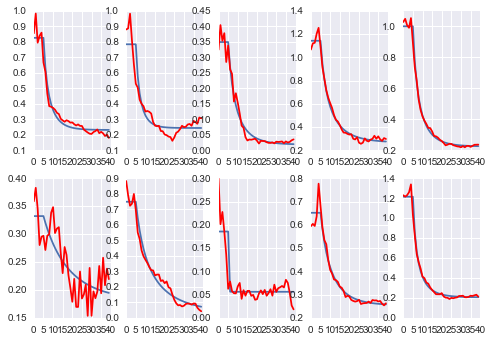

In [383]:
h_store, k_e_store, r_store = [], [], []
for n, cell_ts in enumerate(ee_ratio[:10]):
#     e_tau, e_h, e_r = fmin(fit_ode_lmb, x0=(tau, h, r), args=(time_pre, time_post, cell_ts, estimated_k_v), disp=False)
    ret = minimize(fit_ode_lmb, x0=(tau, h, r), args=(time_pre, time_post, cell_ts, estimated_k_v), bounds=bnds)
    sim, dat = calc_sim_ratio([ret.x[0], ret.x[1], ret.x[2]], time_pre, time_post, cell_ts, estimated_k_v)
    plt.subplot(2, 5, n+1)
    plt.plot(sim)
    plt.hold(True)
    plt.plot(dat, 'r')
    
    
    k_e_store.append(ret.x[0])
    h_store.append(ret.x[1])
    r_store.append(ret.x[2])


['status', 'success', 'nfev', 'hess_inv', 'fun', 'x', 'message', 'jac', 'nit']

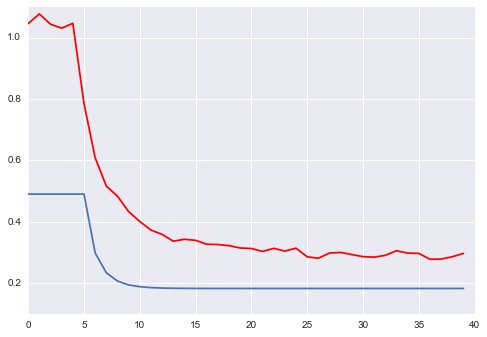

In [380]:
sim, dat = calc_sim_ratio([np.mean(k_e_store), estim_h, np.mean(r_store)], time_pre, time_post, ee_ratio[10], estimated_k_v)
# sim, dat = calc_sim_ratio([0.2, 0.25, 0.8], time_pre, time_post, ee_ratio[20], 4)
plt.plot(sim)
plt.hold(True)
plt.plot(dat, 'r')


## Estimation of k_du, k_dn, Kmd

In [ ]:
'''
k_dc = 0.03  # uM/min, dephosphorylation Vmax of reporter in cytosol
k_dn = 0.03  # uM/min, dephosphorylation Vmax of reporter in nucleus
Kmd = 0.1  # uM, Michaelis constant for dephosphorylation of reporter
We use the estimated k_iu, k_eu, k_ip and k_ep. 
'''

## Absolute kinase concentration

In [ ]:
parent_folder = '/Users/kudo/gdrive/GitHub/covertrace/data/IL1B'
sub_folders = ['Pos005', 'Pos007', 'Pos008']
conditions = ['IL1B', 'IL1B', 'LPS']
sites = Sites(parent_folder, sub_folders, conditions, file_name='df.npz')

In [ ]:
sites.staged.state = ['cytoplasm', 'TRITC', 'median_ratio']
plot_all = partial(ops_plotter.plot_all)
fig, axes = sites.iterate(plot_all)

In [ ]:
#You see some outliers. 

In [ ]:
sites.staged.state = ['nuclei', 'TRITC', 'median_intensity']
plot_all_log = partial(ops_plotter.plot_all, logy=True)
fig, axes = sites.iterate(plot_all_log)

In [ ]:
ops_bool.filter_frames_by_range?
op = partial(ops_bool.filter_frames_by_range, LOWER=400, UPPER=3000)
sites.iterate(op, 1)
sites.propagate_prop(pid=1)
fig, axes = sites.iterate(plot_all)

In [ ]:
sites.staged.state = ['cytoplasm', 'TRITC', 'median_ratio']
fig, axes = sites.iterate(plot_all)

In [ ]:
sites.drop_prop(pid=1)

In [ ]:
sites.staged.state = ['nuclei', 'TRITC', 'median_intensity']
fig, axes = sites.iterate(plot_all_log)

In [ ]:
sites.staged.state = ['cytoplasm', 'TRITC', 'median_ratio']
fig, axes = sites.iterate(plot_all)

In [ ]:
# sites.reset_prop()
sites.staged.state = ['cytoplasm', 'TRITC', 'mean_intensity']
func = partial(ops_plotter.plot_histogram_pdstats)
fig, axes = sites.iterate(func)
sites.reset_prop()

In [ ]:
sites.reset_prop()
cytorange = partial(ops_bool.filter_frames_by_range, LOWER=50, UPPER=300)
sites.iterate(cytorange, pid=1)
sites.propagate_prop(pid=1)
sites.staged.state = ['cytoplasm', 'TRITC', 'median_ratio']
fig, axes = sites.iterate(plot_all)

In [ ]:
sites.staged.state = ['cytoplasm', 'TRITC', 'median_ratio']
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)

In [ ]:
sites.staged.state = ['nuclei', 'TRITC', 'median_intensity']
plot_all_log = partial(ops_plotter.plot_all, logy=True)
fig, axes = sites.iterate(plot_all_log)

In [ ]:
sites.Pos005.data.labels